In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import datetime
from statsmodels.formula.api import ols
import scipy.stats as stats

In [14]:
df_tel = pd.read_csv('000_Telemarketing_Data.csv', encoding='utf-8')
df_tel.head()

,연령,직업군,결혼여부,학력,신용카드소지여부,주택대출여부,개인대출여부,contact,통화시간,연락시도횟수,p_days,과거통화횟수,계약여부,연락일자,카드종류
0,56,주부,결혼,중졸,없음,없음,없음,유선전화,261,1,NaN,0,no,2018-01-03,87
1,57,서비스종사자,결혼,전문학교,미확인,없음,없음,유선전화,149,1,NaN,0,no,2018-01-03,88
2,37,서비스종사자,결혼,전문학교,없음,대출있음,없음,유선전화,226,1,NaN,0,no,2018-01-03,89
3,40,회사원,결혼,검정고시,없음,없음,없음,유선전화,151,1,NaN,0,no,2018-01-03,90
4,56,서비스종사자,결혼,전문학교,없음,없음,대출있음,유선전화,307,1,NaN,0,no,2018-01-03,91


In [4]:
df_tel['직업군'].value_counts()

회사원       10422
산업노동자      9254
기술자        6743
서비스종사자     3969
공무원        2924
은퇴         1720
기업가        1456
자영업자       1421
주부         1060
미취업자       1014
학생          875
미확인         330
Name: 직업군, dtype: int64

In [ ]:
df_tel['p_days'].fillna('안함', inplace=True)
df_tel['재연락'] = np.where(df_tel['p_days'] == '안함', 0, 1)

In [5]:
call_g = df_tel.groupby('통화시간')['계약여부'].count()
df_yes = df_tel[df_tel['계약여부'] == 'yes']
call_yes = df_yes.groupby('통화시간')['계약여부'].count()

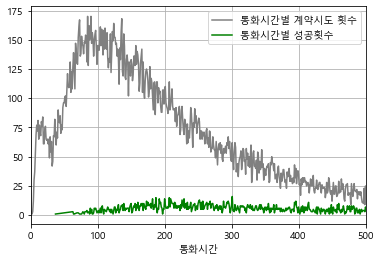

In [5]:
call_g.plot(color='grey', label='통화시간별 계약시도 횟수')
call_yes.plot(color='green', label='통화시간별 성공횟수')
plt.xlim([0,500])
plt.grid()
plt.legend()

In [6]:
df_tel['통화시간'].describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: 통화시간, dtype: float64

<AxesSubplot:xlabel='통화시간대', ylabel='count'>

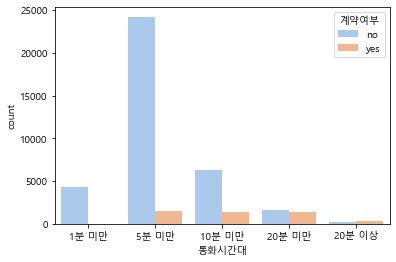

In [7]:
bins = [0,60,300,600,1200,4918]
df_tel['통화시간대'] = pd.cut(df_tel['통화시간'], bins=bins, labels = ['1분 미만','5분 미만','10분 미만','20분 미만', '20분 이상'])
sns.set_palette('pastel')
sns.countplot(data=df_tel, x = '통화시간대', hue='계약여부')

,통화시간대,연락시도횟수
0,1분 미만,4282
1,5분 미만,25698
2,10분 미만,7740
3,20분 미만,2951
4,20분 이상,513


<AxesSubplot:xlabel='통화시간대', ylabel='연락시도횟수'>

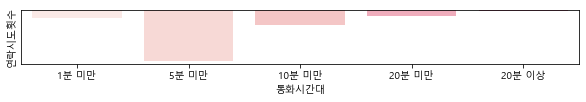

In [8]:
sequential_colors = sns.color_palette("RdPu", 10)
sns.palplot(sequential_colors)

p_call = pd.pivot_table(data=df_tel, index=['통화시간대'], values=['연락시도횟수'], aggfunc='count').reset_index()
# order_list = p_call.sort_values(by='연락시도횟수', ascending=False)['통화시간대'].to_list()
display(p_call)
sns.barplot(data=p_call, x='통화시간대', y='연락시도횟수', palette = sequential_colors)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1분 미만'),
  Text(1, 0, '5분 미만'),
  Text(2, 0, '10분 미만'),
  Text(3, 0, '20분 미만'),
  Text(4, 0, '20분 이상')])

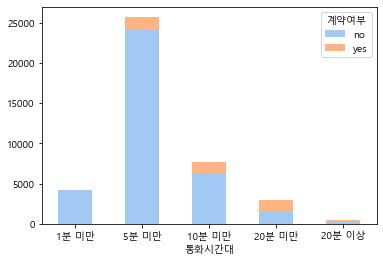

In [9]:
call_time_g = df_tel.groupby(['통화시간대', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
call_time_g.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)

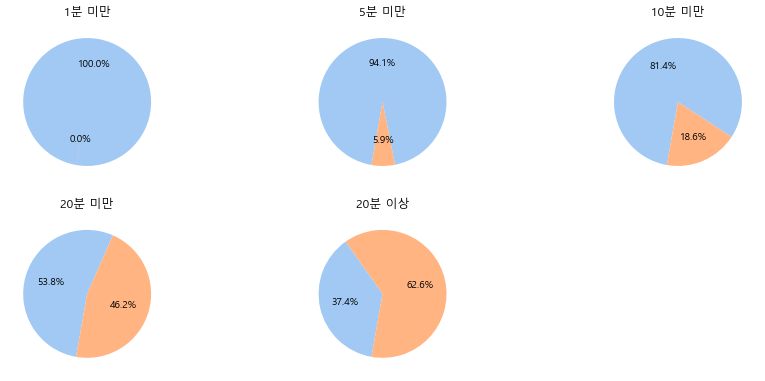

In [10]:
x = 1
plt.figure(figsize=(15,10))
while x <= len(call_time_g):
    for i in call_time_g.values:
        data = []
        data.append(i[0])
        data.append(i[1])
        plt.subplot(3,3,x)
        plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
        plt.title(call_time_g.index[x-1])
        x += 1

In [11]:
display(call_time_g)
chi, pval, dof, expected = stats.chi2_contingency(observed = call_time_g)
print('chi-square test')
print('chisq : {0:.3f}'.format(chi))
print('p : {0:3f}'.format(pval))
display(pd.DataFrame(expected.round(0)))

계약여부,no,yes
통화시간대,,
1분 미만,4281,1
5분 미만,24181,1517
10분 미만,6302,1438
20분 미만,1588,1363
20분 이상,192,321


chi-square test
chisq : 6645.353
p : 0.000000


,0,1
0,3800.0,482.0
1,22803.0,2895.0
2,6868.0,872.0
3,2619.0,332.0
4,455.0,58.0


In [12]:
def job_call_time(df, val):
    globals()['df_job_{}'.format(val)] = df[df['직업군'] == val]
    job_call_t = globals()['df_job_{}'.format(val)].groupby(['통화시간대', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
    
    job_call_t.plot(kind='bar', stacked=True)
    plt.xticks(rotation=0)
    plt.title(f'{val}의 통화시간대별 계약여부')
    
    x = 1
    plt.figure(figsize=(15,10))
    while x <= len(job_call_t):
        for i in job_call_t.values:
            data = []
            data.append(i[0])
            data.append(i[1])
            plt.subplot(3,3,x)
            plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
            plt.title(job_call_t.index[x-1])
            x += 1    

In [13]:
df_tel['직업군'].unique()

array(['주부', '서비스종사자', '회사원', '산업노동자', '기술자', '은퇴', '공무원', '미취업자', '자영업자',
       '미확인', '기업가', '학생'], dtype=object)

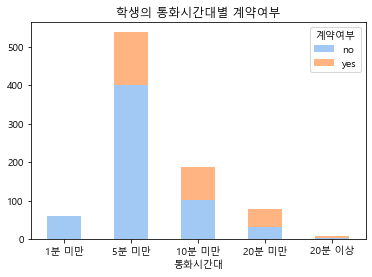

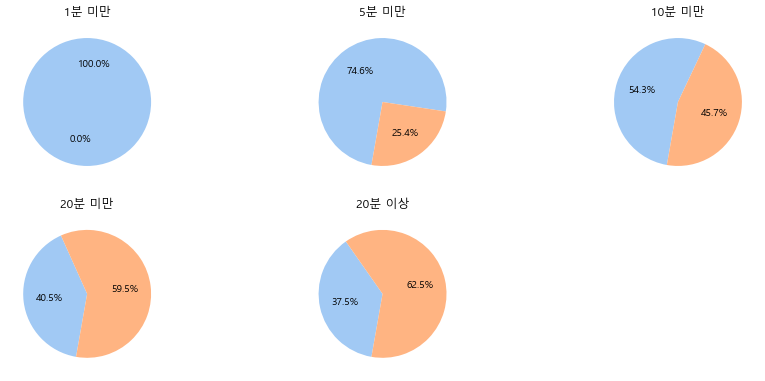

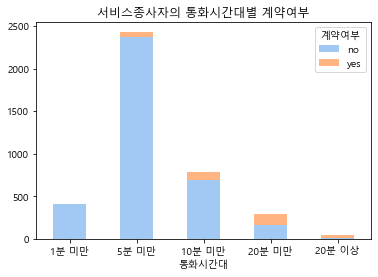

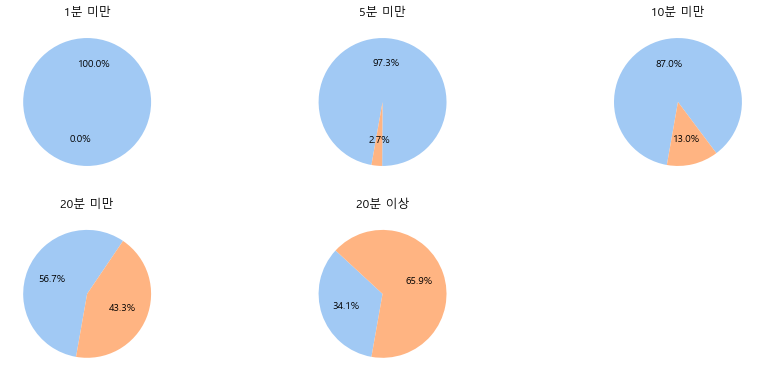

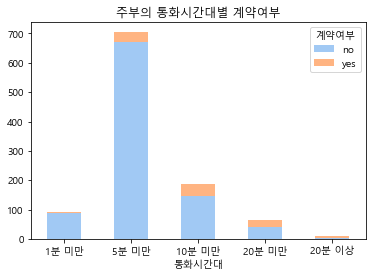

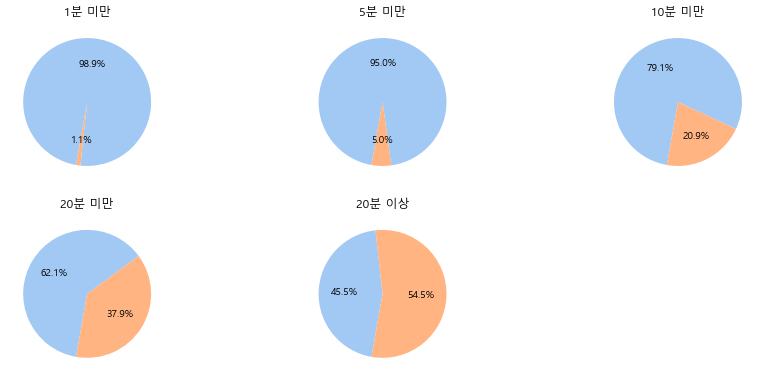

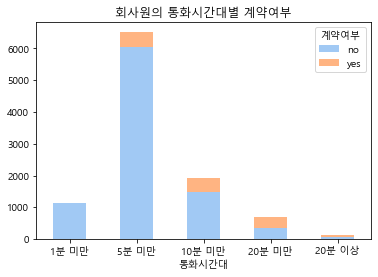

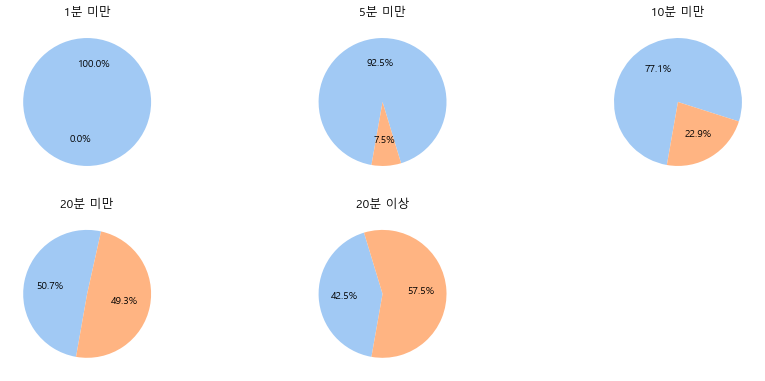

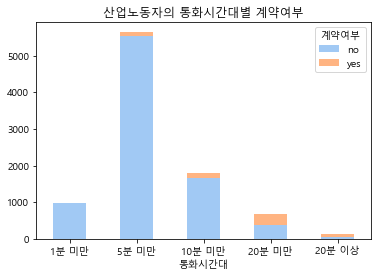

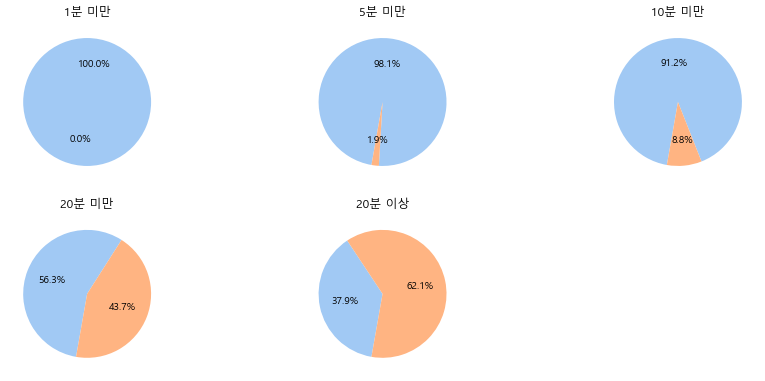

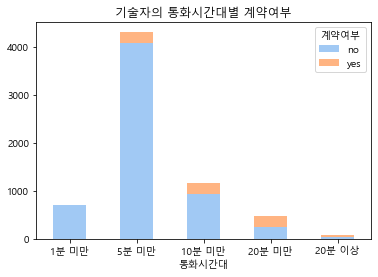

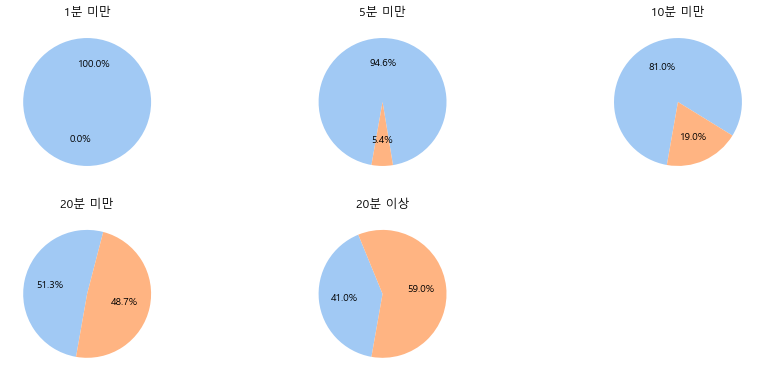

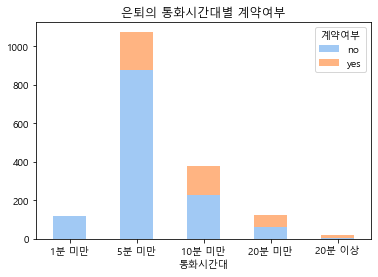

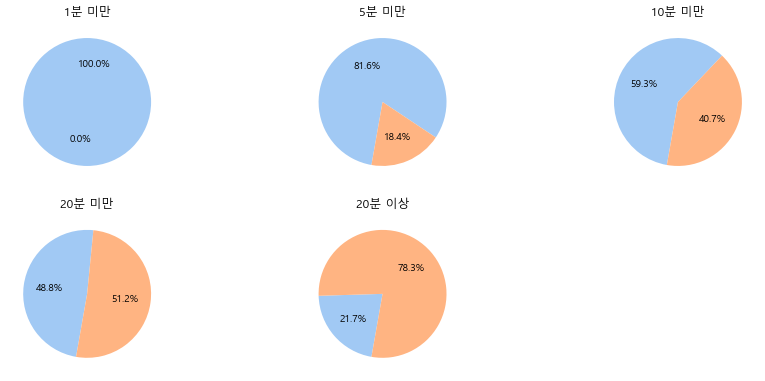

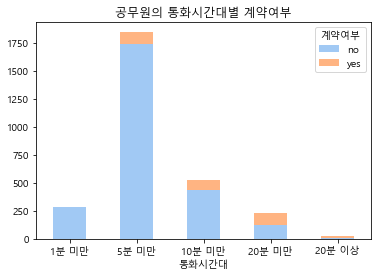

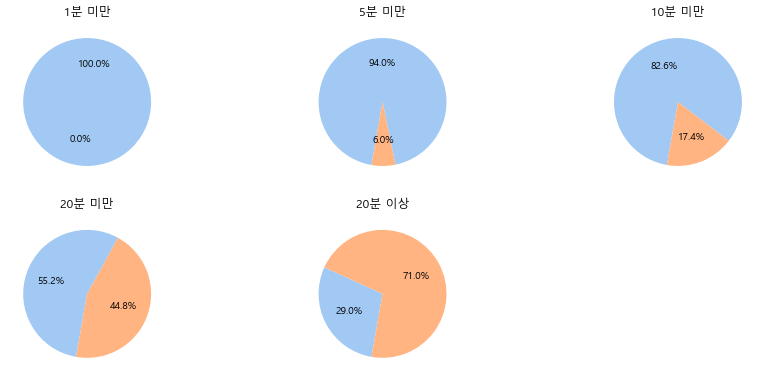

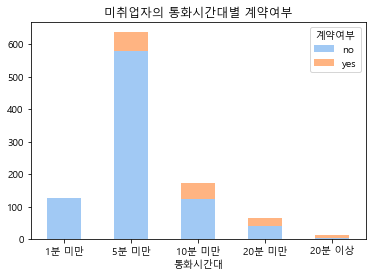

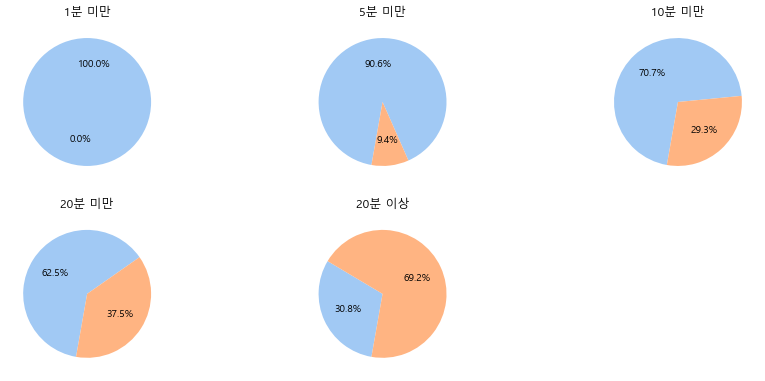

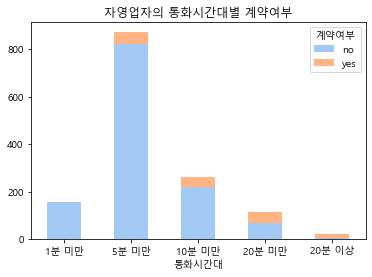

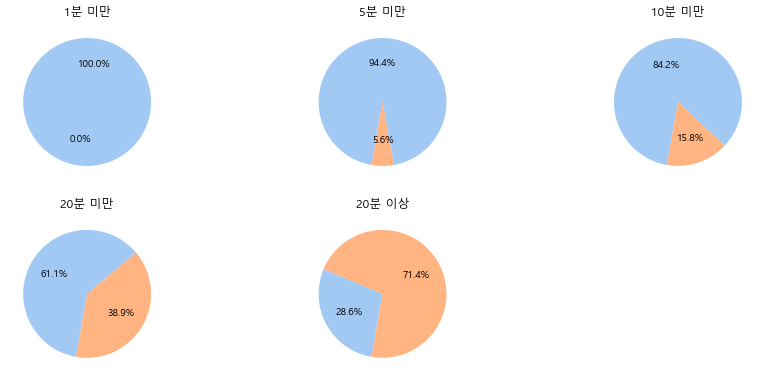

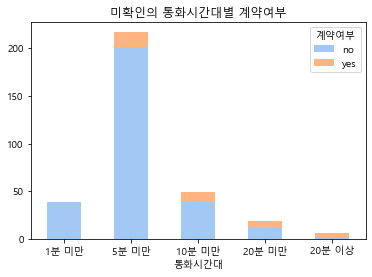

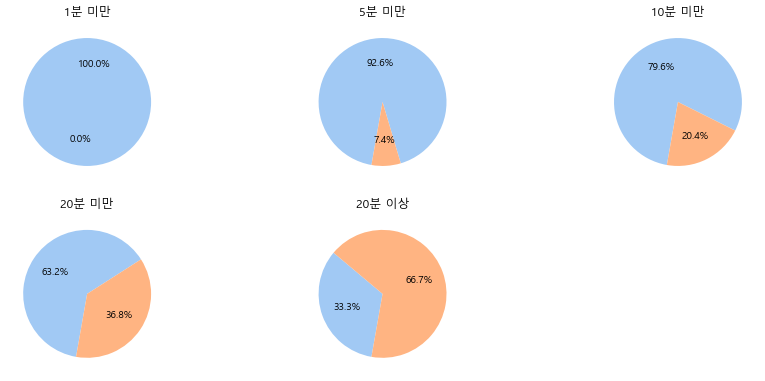

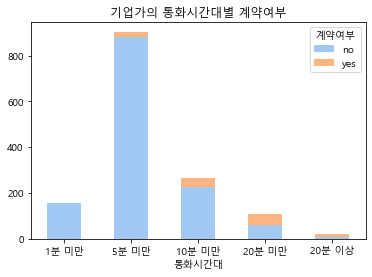

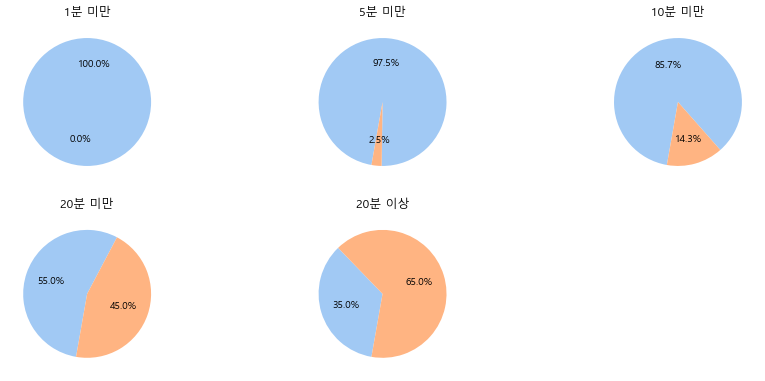

In [14]:
job_call_time(df_tel, '학생')
job_call_time(df_tel, '서비스종사자')
job_call_time(df_tel, '주부')
job_call_time(df_tel, '회사원')
job_call_time(df_tel, '산업노동자')
job_call_time(df_tel, '기술자')
job_call_time(df_tel, '은퇴')
job_call_time(df_tel, '공무원')
job_call_time(df_tel, '미취업자')
job_call_time(df_tel, '자영업자')
job_call_time(df_tel, '미확인')
job_call_time(df_tel, '기업가')

<AxesSubplot:xlabel='Age', ylabel='count'>

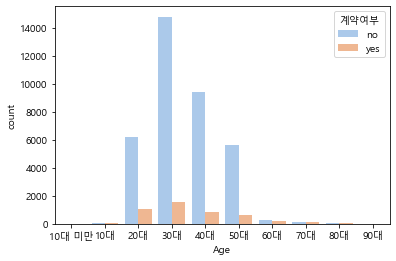

In [15]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df_tel['Age'] = pd.cut(df_tel['연령'], bins=bins, labels = ['10대 미만', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대','90대'])
sns.set_palette('pastel')
sns.countplot(data=df_tel, x = 'Age', hue='계약여부')

In [16]:
def age_call_time(df, val):
    globals()['df_job_{}'.format(val)] = df[df['Age'] == val]
    age_call_t = globals()['df_job_{}'.format(val)].groupby(['통화시간대', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
    print(globals()['df_job_{}'.format(val)]['통화시간'].mean())
    age_call_t.plot(kind='bar', stacked=True)
    plt.xticks(rotation=0)
    plt.title(f'{val}의 통화시간대별 계약여부')
    
    x = 1
    plt.figure(figsize=(15,10))
    while x <= len(age_call_t):
        for i in age_call_t.values:
            data = []
            data.append(i[0])
            data.append(i[1])
            plt.subplot(3,3,x)
            plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
            plt.title(age_call_t.index[x-1])
            x += 1

294.75
263.3410189148143
255.87287152883735
256.584375
258.44896331738437
275.0532786885246
273.73597359735976
256.1284403669725
413.7


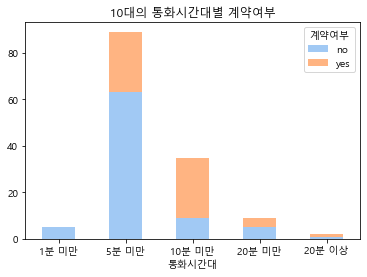

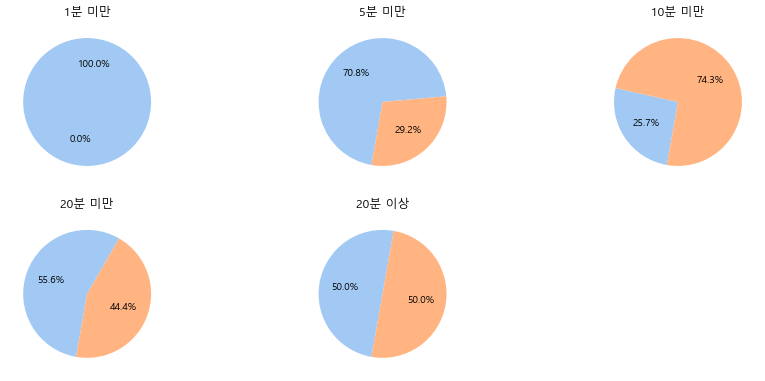

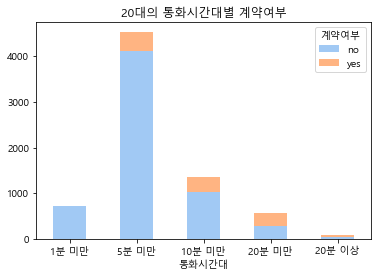

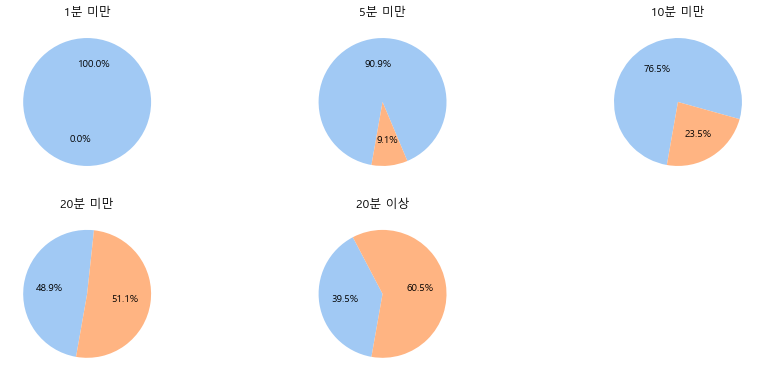

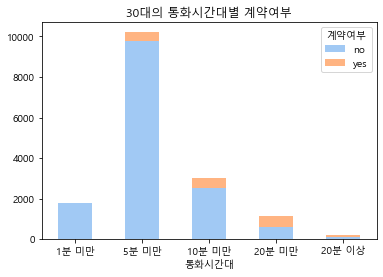

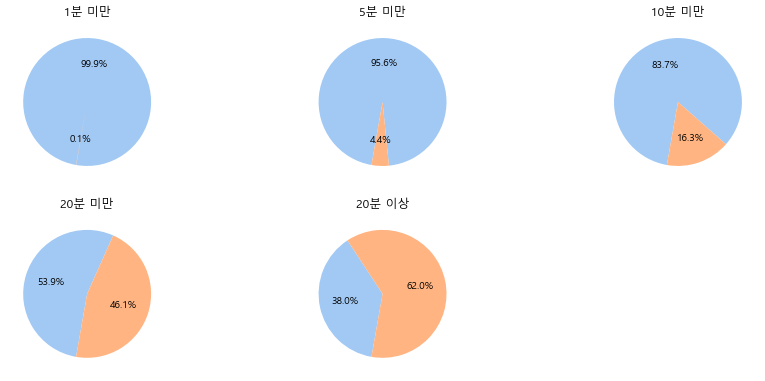

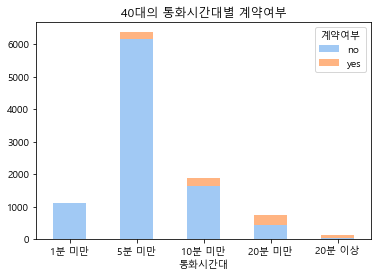

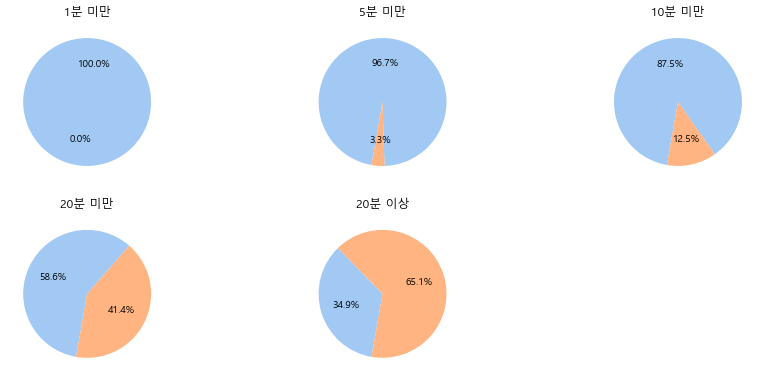

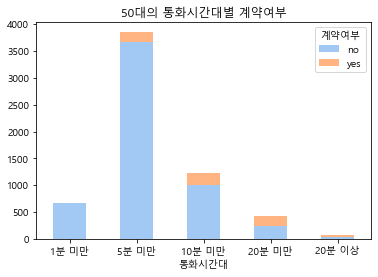

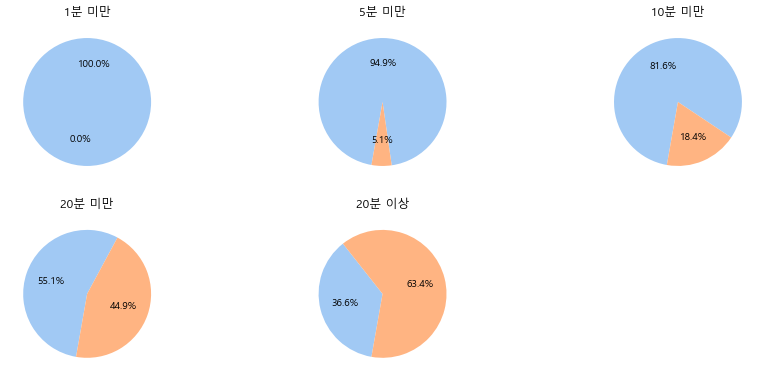

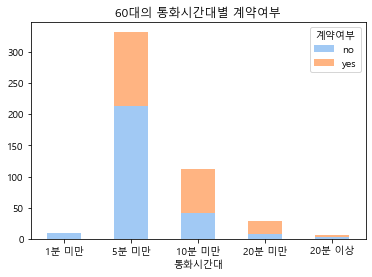

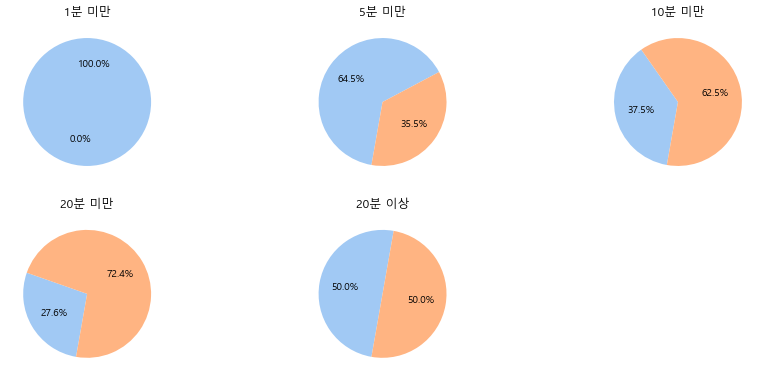

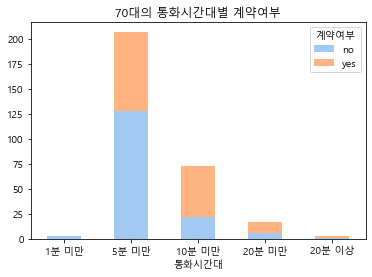

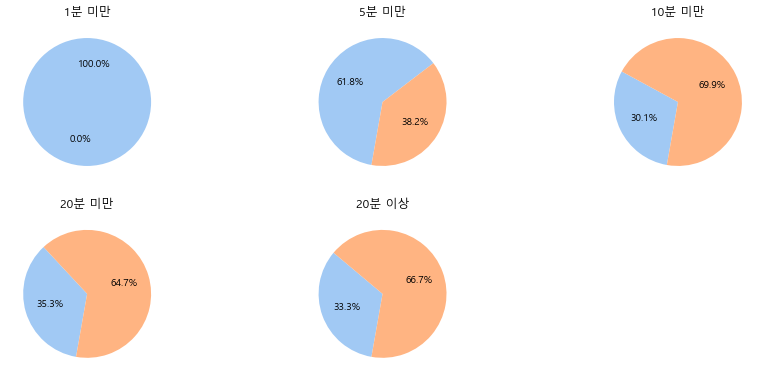

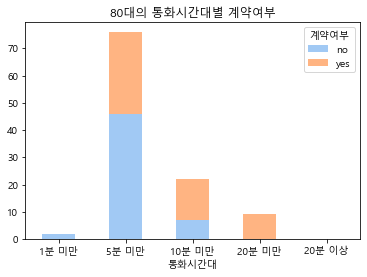

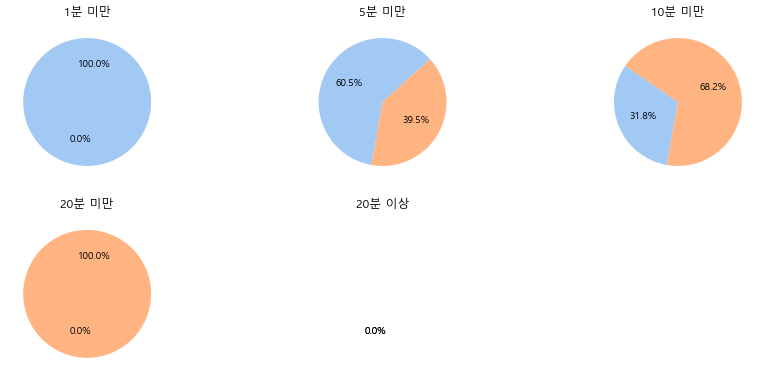

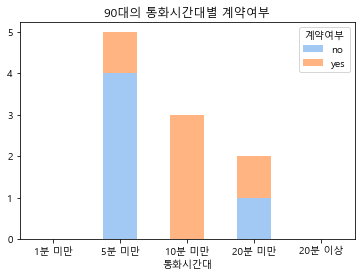

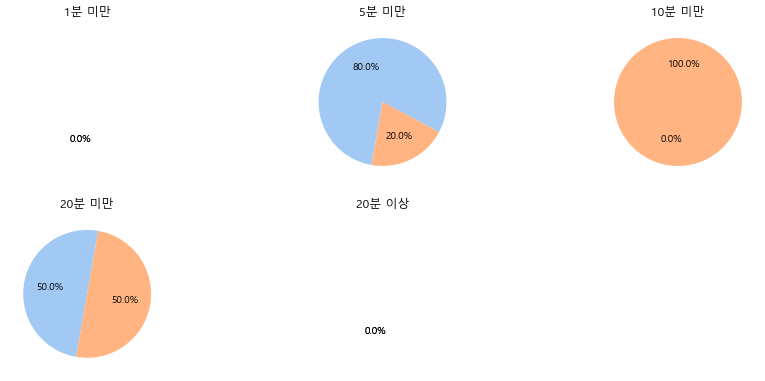

In [17]:
age_call_time(df_tel, '10대')
age_call_time(df_tel, '20대')
age_call_time(df_tel, '30대')
age_call_time(df_tel, '40대')
age_call_time(df_tel, '50대')
age_call_time(df_tel, '60대')
age_call_time(df_tel, '70대')
age_call_time(df_tel, '80대')
age_call_time(df_tel, '90대')

In [18]:
def marry_call_time(df, val):
    globals()['df_job_{}'.format(val)] = df[df['결혼여부'] == val]
    marry_call_t = globals()['df_job_{}'.format(val)].groupby(['통화시간대', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
    
    marry_call_t.plot(kind='bar', stacked=True)
    plt.xticks(rotation=0)
    plt.title(f'{val}의 통화시간대별 계약여부')
    
    x = 1
    plt.figure(figsize=(15,10))
    while x <= len(marry_call_t):
        for i in marry_call_t.values:
            data = []
            data.append(i[0])
            data.append(i[1])
            plt.subplot(3,3,x)
            plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
            plt.title(marry_call_t.index[x-1])
            x += 1

In [19]:
df_tel['결혼여부'].unique()

array(['결혼', '미혼', '이혼', '미확인'], dtype=object)

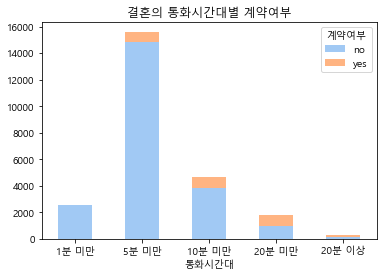

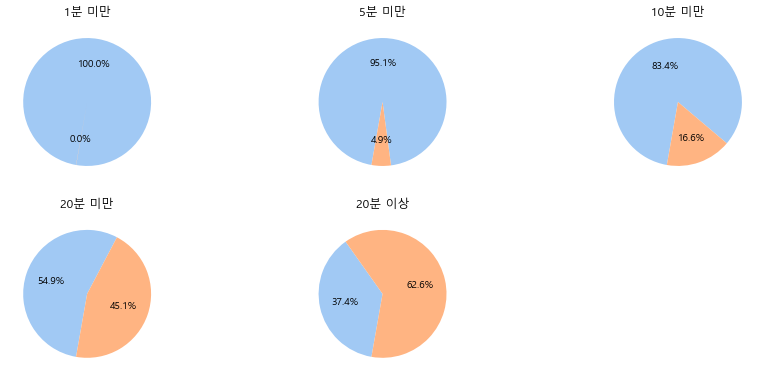

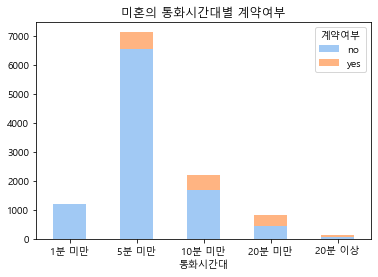

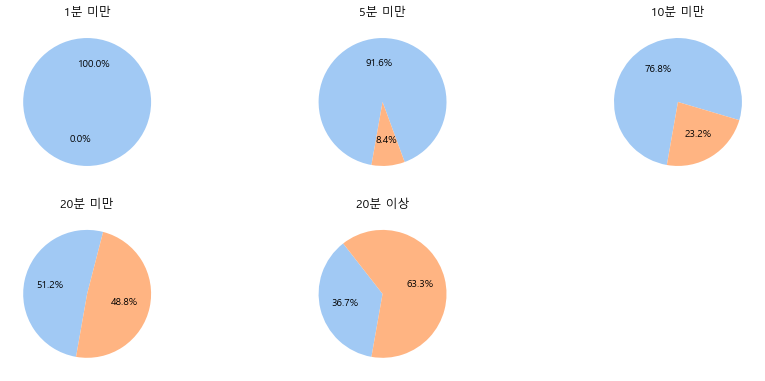

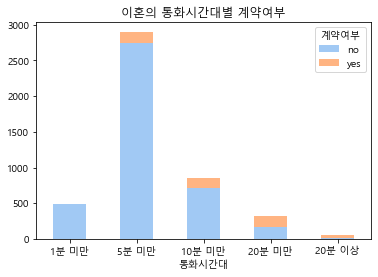

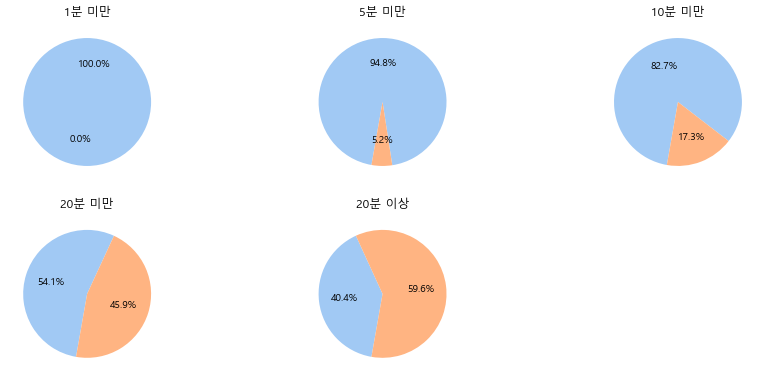

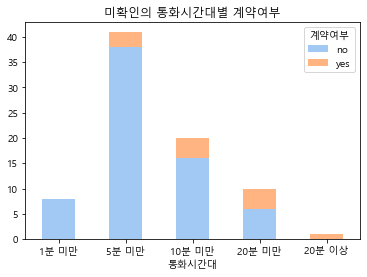

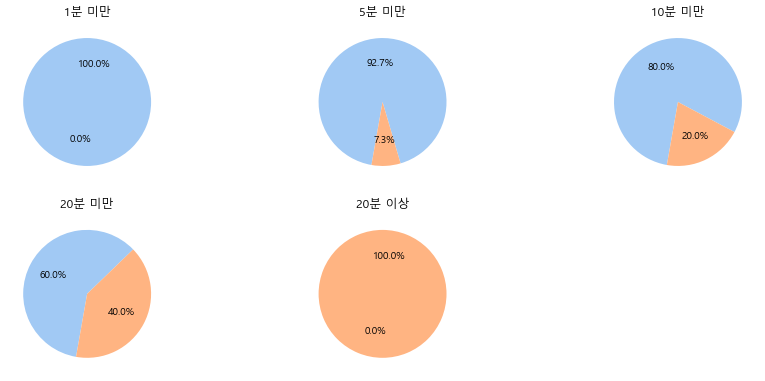

In [20]:
marry_call_time(df_tel, '결혼')
marry_call_time(df_tel, '미혼')
marry_call_time(df_tel, '이혼')
marry_call_time(df_tel, '미확인')

<AxesSubplot:xlabel='통화시간대2', ylabel='count'>

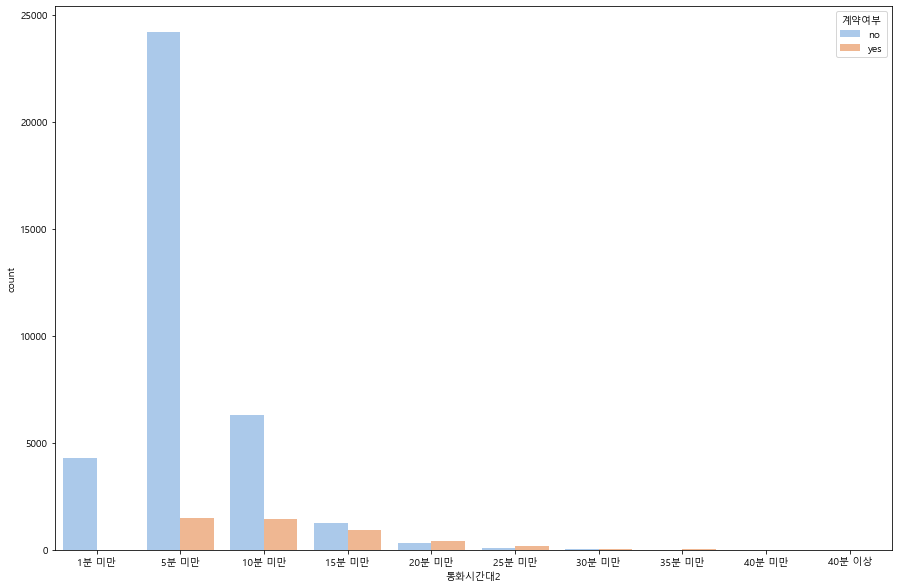

In [16]:
bins_2 = [0,60,300,600,900,1200,1500,1800,2100,2400,4918]
df_tel['통화시간대2'] = pd.cut(df_tel['통화시간'], bins=bins_2, labels = ['1분 미만','5분 미만','10분 미만','15분 미만', '20분 미만', '25분 미만', '30분 미만', '35분 미만', '40분 미만', '40분 이상'])
plt.figure(figsize=(15,10))
sns.set_palette('pastel')
sns.countplot(data=df_tel, x = '통화시간대2', hue='계약여부')

chi-square test
chisq : 6645.353
p : 0.000000


계약여부,no,yes
통화시간대2,,
1분 미만,4281,1
5분 미만,24181,1517
10분 미만,6302,1438
15분 미만,1259,924
20분 미만,329,439
25분 미만,115,192
30분 미만,36,69
35분 미만,22,34
40분 미만,6,8


,0,1
0,3800.0,482.0
1,22803.0,2895.0
2,6868.0,872.0
3,2619.0,332.0
4,455.0,58.0


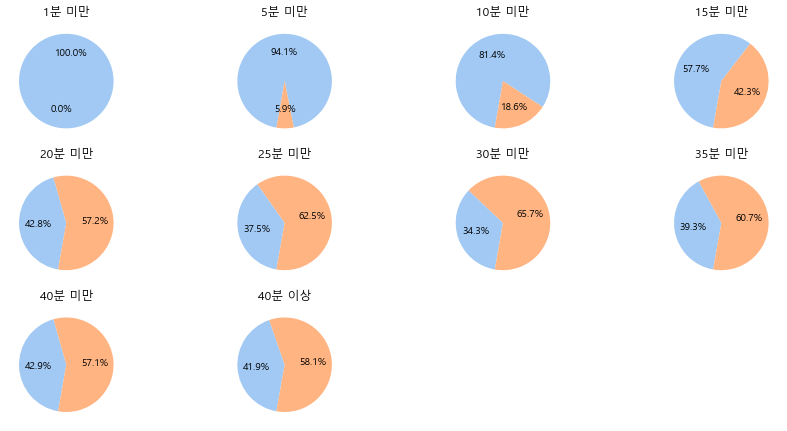

In [39]:
call_time_g2 = df_tel.groupby(['통화시간대2', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
x = 1
plt.figure(figsize=(15,10))
while x <= len(call_time_g2):
    for i in call_time_g2.values:
        data = []
        data.append(i[0])
        data.append(i[1])
        plt.subplot(4,4,x)
        plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
        plt.title(call_time_g2.index[x-1])
        x += 1
        

chi, pval, dof, expected = stats.chi2_contingency(observed = call_time_g)
print('chi-square test')
print('chisq : {0:.3f}'.format(chi))
print('p : {0:3f}'.format(pval))
display(call_time_g2)
display(pd.DataFrame(expected.round(0)))

In [37]:
age_20 = df_tel[df_tel['Age'] == '20대']['직업군'].unique().tolist()
age_30 = df_tel[df_tel['Age'] == '30대']['직업군'].unique().tolist()
age_40 = df_tel[df_tel['Age'] == '40대']['직업군'].unique().tolist()
age_50 = df_tel[df_tel['Age'] == '50대']['직업군'].unique().tolist()
age_60 = df_tel[df_tel['Age'] == '60대']['직업군'].unique().tolist()
age_70 = df_tel[df_tel['Age'] == '70대']['직업군'].unique().tolist()
age_80 = df_tel[df_tel['Age'] == '80대']['직업군'].unique().tolist()
age_90 = df_tel[df_tel['Age'] == '90대']['직업군'].unique().tolist()

In [51]:
call_time_g2['%'] = (call_time_g2['yes'] / (call_time_g2['no'] + call_time_g2['yes']))*100
call_time_g2

계약여부,no,yes,%
통화시간대2,,,
1분 미만,4281,1,0.023354
5분 미만,24181,1517,5.903183
10분 미만,6302,1438,18.578811
15분 미만,1259,924,42.327073
20분 미만,329,439,57.161458
25분 미만,115,192,62.540717
30분 미만,36,69,65.714286
35분 미만,22,34,60.714286
40분 미만,6,8,57.142857


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '1분 미만'),
  Text(1, 0, '5분 미만'),
  Text(2, 0, '10분 미만'),
  Text(3, 0, '15분 미만'),
  Text(4, 0, '20분 미만'),
  Text(5, 0, '25분 미만'),
  Text(6, 0, '30분 미만'),
  Text(7, 0, '35분 미만'),
  Text(8, 0, '40분 미만'),
  Text(9, 0, '40분 이상')])

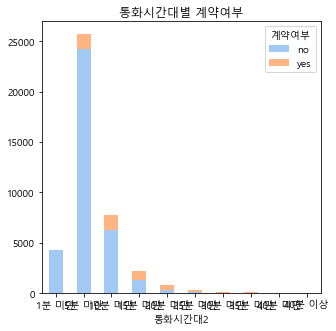

In [39]:
call_time_g = df_tel.groupby(['통화시간대2', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
call_time_g.plot(kind='bar', stacked=True, figsize=(5,5))
plt.title('통화시간대별 계약여부')
plt.xticks(rotation=0)

In [85]:
df_call = df_tel[(df_tel['Age'] == '20대') & (df_tel['직업군'] == '기술자')]
call_time = df_call.groupby(['통화시간대2', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
call_time['%'] = (call_time['yes'] / (call_time['no'] + call_time['yes']))*100
idx = call_time.loc[(call_time['no'] == 0) | (call_time['yes'] == 0)].index
call_time = call_time.drop(idx)
call_time

계약여부,no,yes,%
통화시간대2,,,
5분 미만,684,53,7.191316
10분 미만,157,51,24.519231
15분 미만,35,28,44.444444
20분 미만,10,16,61.538462
25분 미만,1,5,83.333333


In [90]:
def job_age_call(df, val ,y):
    df_call = df[(df['Age'] == val) & (df['직업군'] == y)]
    call_time = df_call.groupby(['통화시간대2', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
    idx = call_time.loc[(call_time['no'] == 0) | (call_time['yes'] == 0)].index
    call_time = call_time.drop(idx)
    call_time['%'] = (call_time['yes'] / (call_time['no'] + call_time['yes']))*100
    x = 1
    plt.figure(figsize=(15,10))
    while x <= len(call_time):
        for i in call_time.values:
            data = []
            data.append(i[0])
            data.append(i[1])
            plt.subplot(4,4,x)
            plt.pie(data,autopct='%.1f%%', startangle=260, counterclock=False)
            plt.title(call_time.index[x-1])
            x += 1

    chi, pval, dof, expected = stats.chi2_contingency(observed = call_time)
    print(f'chi-square test : {val}인 {y}')
    print('chisq : {0:.3f}'.format(chi))
    print('p : {0:3f}'.format(pval))
    display(call_time)
    display(pd.DataFrame(expected.round(0)))

chi-square test : 20대인 기술자
chisq : 821.527
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,684,53,7.191316
10분 미만,157,51,24.519231
15분 미만,35,28,44.444444
20분 미만,10,16,61.538462
25분 미만,1,5,83.333333


,0,1,2
0,523.0,90.0,130.0
1,164.0,28.0,41.0
2,76.0,13.0,19.0
3,62.0,11.0,15.0
4,63.0,11.0,16.0


chi-square test : 20대인 서비스종사자
chisq : 765.091
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,534,21,3.783784
10분 미만,156,33,17.460317
15분 미만,31,24,43.636364
20분 미만,7,7,50.000000
25분 미만,4,3,42.857143
30분 미만,1,2,66.666667


,0,1,2
0,391.0,48.0,120.0
1,144.0,18.0,44.0
2,69.0,8.0,21.0
3,45.0,5.0,14.0
4,35.0,4.0,11.0
5,49.0,6.0,15.0


chi-square test : 20대인 산업노동자
chisq : 1352.107
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,880,29,3.190319
10분 미만,247,21,7.835821
15분 미만,48,39,44.827586
20분 미만,9,21,70.000000
25분 미만,6,6,50.000000
30분 미만,1,2,66.666667
35분 미만,2,2,50.000000
40분 이상,2,1,33.333333


,0,1,2
0,664.0,67.0,181.0
1,201.0,20.0,55.0
2,96.0,10.0,26.0
3,73.0,7.0,20.0
4,45.0,5.0,12.0
5,51.0,5.0,14.0
6,39.0,4.0,11.0
7,26.0,3.0,7.0


chi-square test : 20대인 미취업자
chisq : 185.500
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,94,16,14.545455
10분 미만,17,13,43.333333
15분 미만,2,4,66.666667
20분 미만,1,1,50.000000


,0,1,2
0,44.0,13.0,67.0
1,26.0,8.0,40.0
2,26.0,8.0,39.0
3,18.0,5.0,28.0


chi-square test : 20대인 공무원
chisq : 323.875
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,163,12,6.857143
10분 미만,34,9,20.930233
15분 미만,9,11,55.000000
20분 미만,1,5,83.333333
25분 미만,1,1,50.000000


,0,1,2
0,82.0,15.0,85.0
1,29.0,5.0,30.0
2,34.0,6.0,35.0
3,40.0,7.0,42.0
4,23.0,4.0,24.0


chi-square test : 20대인 회사원
chisq : 1322.738
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,1205,155,11.397059
10분 미만,273,120,30.534351
15분 미만,62,58,48.333333
20분 미만,16,20,55.555556
25분 미만,8,12,60.000000
30분 미만,1,2,66.666667


,0,1,2
0,974.0,228.0,170.0
1,301.0,71.0,52.0
2,120.0,28.0,21.0
3,65.0,15.0,11.0
4,57.0,13.0,10.0
5,49.0,12.0,9.0


chi-square test : 20대인 학생
chisq : 409.783
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,278,102,26.842105
10분 미만,73,52,41.600000
15분 미만,14,25,64.102564
20분 미만,6,7,53.846154
25분 미만,1,3,75.000000


,0,1,2
0,184.0,93.0,129.0
1,75.0,38.0,53.0
2,47.0,24.0,33.0
3,30.0,15.0,21.0
4,36.0,18.0,25.0


chi-square test : 20대인 미확인
chisq : 42.944
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,19,3,13.636364
10분 미만,3,1,25.000000
15분 미만,2,3,60.000000


,0,1,2
0,7.0,2.0,27.0
1,5.0,2.0,22.0
2,12.0,4.0,49.0


chi-square test : 20대인 자영업자
chisq : 245.130
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,150,19,11.242604
10분 미만,36,10,21.739130
15분 미만,2,6,75.000000
20분 미만,2,2,50.000000


,0,1,2
0,89.0,17.0,74.0
1,33.0,7.0,28.0
2,41.0,8.0,34.0
3,27.0,5.0,22.0


chi-square test : 20대인 주부
chisq : 83.957
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,37,1,2.631579
10분 미만,5,1,16.666667
15분 미만,4,2,33.333333
20분 미만,2,1,33.333333


,0,1,2
0,14.0,1.0,25.0
1,8.0,1.0,14.0
2,14.0,1.0,24.0
3,13.0,1.0,22.0


chi-square test : 20대인 기업가
chisq : 88.441
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,71,2,2.739726
10분 미만,28,5,15.151515
15분 미만,8,6,42.857143


,0,1,2
0,45.0,5.0,25.0
1,29.0,3.0,16.0
2,34.0,4.0,19.0


KeyError: 'yes'

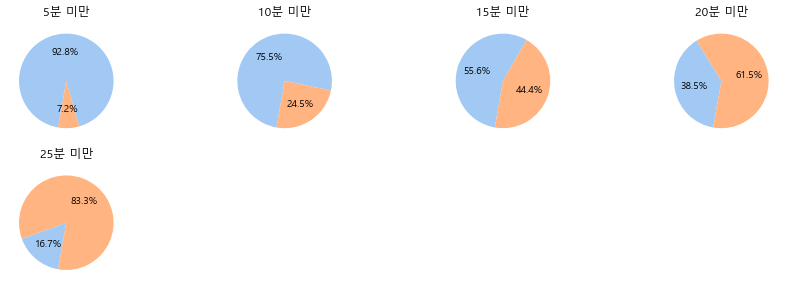

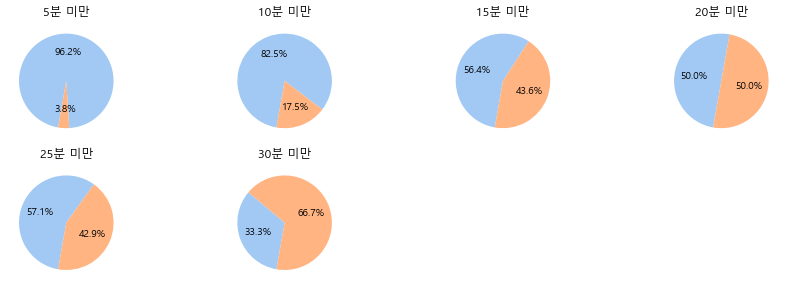

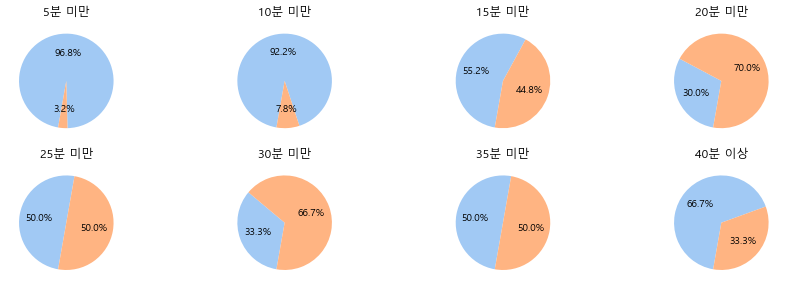

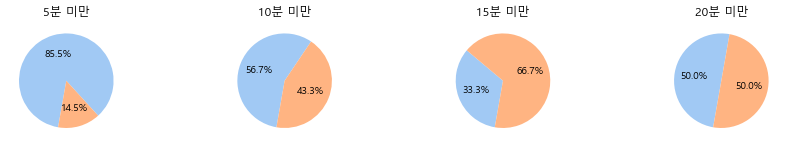

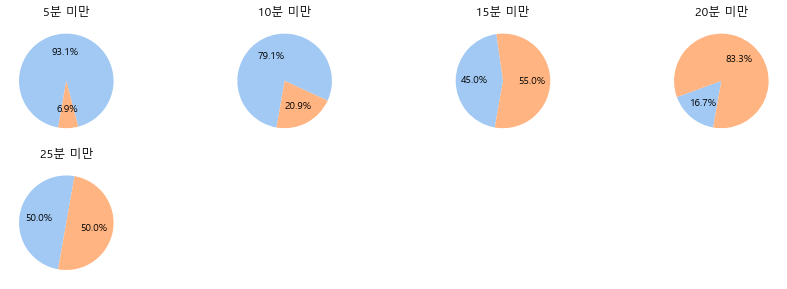

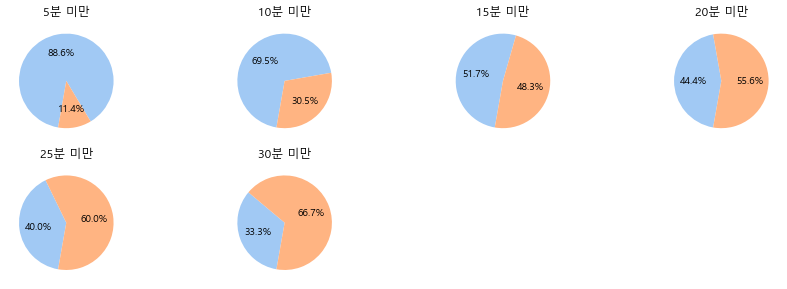

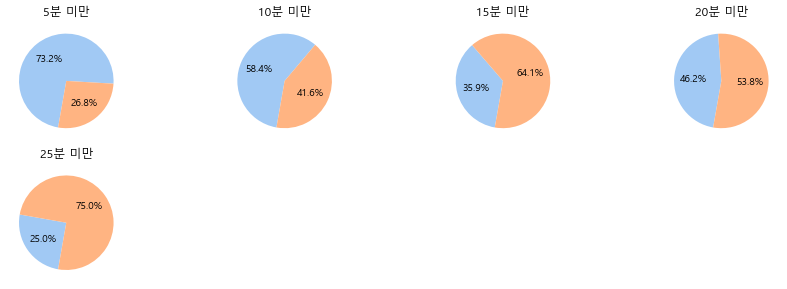

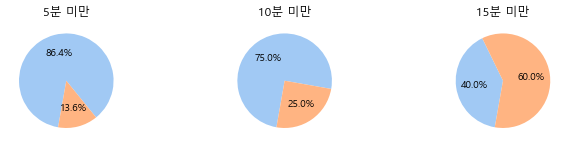

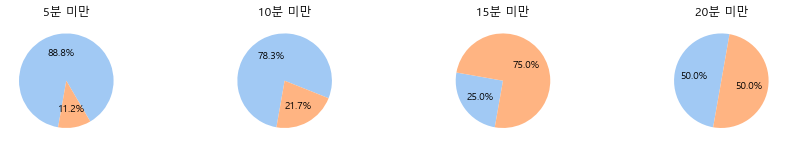

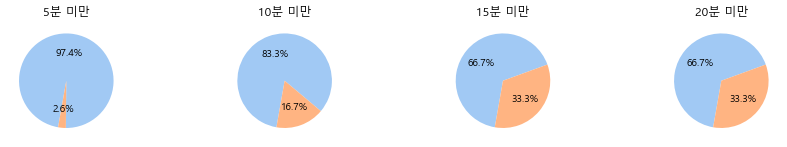

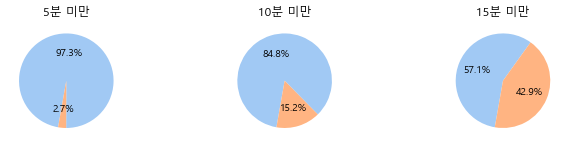

In [91]:
for i in range(len(age_20)):
    job_age_call(df_tel, '20대', age_20[i])
    
for i in range(len(age_30)):
    job_age_call(df_tel, '30대', age_30[i])

for i in range(len(age_30)):
    job_age_call(df_tel, '40대', age_40[i])

for i in range(len(age_30)):
    job_age_call(df_tel, '50대', age_50[i])
    
for i in range(len(age_30)):
    job_age_call(df_tel, '60대', age_60[i])
    
for i in range(len(age_30)):
    job_age_call(df_tel, '70대', age_70[i])

chi-square test : 30대인 서비스종사자
chisq : 1362.504
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,945,28,2.877698
10분 미만,292,42,12.574850
15분 미만,52,37,41.573034
20분 미만,15,13,46.428571
25분 미만,6,10,62.500000
30분 미만,1,4,80.000000
35분 미만,1,1,50.000000


,0,1,2
0,735.0,76.0,166.0
1,261.0,27.0,59.0
2,98.0,10.0,22.0
3,56.0,6.0,13.0
4,59.0,6.0,13.0
5,64.0,7.0,14.0
6,39.0,4.0,9.0


chi-square test : 30대인 회사원
chisq : 2880.226
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,2750,176,6.015038
10분 미만,674,176,20.705882
15분 미만,128,89,41.013825
20분 미만,37,50,57.471264
25분 미만,16,16,50.000000
30분 미만,7,9,56.250000
35분 미만,4,3,42.857143
40분 미만,2,2,50.000000


,0,1,2
0,2377.0,342.0,213.0
1,706.0,102.0,63.0
2,209.0,30.0,19.0
3,117.0,17.0,10.0
4,66.0,10.0,6.0
5,59.0,8.0,5.0
6,40.0,6.0,4.0
7,44.0,6.0,4.0


chi-square test : 30대인 산업노동자
chisq : 2777.618
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,2253,34,1.486664
10분 미만,677,68,9.127517
15분 미만,108,75,40.983607
20분 미만,35,45,56.250000
25분 미만,12,16,57.142857
30분 미만,2,8,80.000000
35분 미만,4,5,55.555556


,0,1,2
0,1942.0,158.0,189.0
1,640.0,52.0,62.0
2,190.0,15.0,18.0
3,116.0,9.0,11.0
4,72.0,6.0,7.0
5,76.0,6.0,7.0
6,55.0,4.0,5.0


chi-square test : 30대인 공무원
chisq : 686.022
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,646,42,6.104651
10분 미만,156,38,19.587629
15분 미만,36,26,41.935484
20분 미만,11,10,47.619048
25분 미만,4,7,63.636364


,0,1,2
0,513.0,74.0,108.0
1,158.0,23.0,33.0
2,77.0,11.0,16.0
3,51.0,7.0,11.0
4,55.0,8.0,12.0


chi-square test : 30대인 기술자
chisq : 2437.048
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,1947,110,5.347594
10분 미만,446,101,18.464351
15분 미만,81,74,47.741935
20분 미만,25,39,60.937500
25분 미만,8,15,65.217391
30분 미만,1,6,85.714286
35분 미만,3,2,40.000000
40분 이상,1,1,50.000000


,0,1,2
0,1602.0,222.0,238.0
1,439.0,61.0,65.0
2,158.0,22.0,23.0
3,97.0,13.0,14.0
4,69.0,9.0,10.0
5,72.0,10.0,11.0
6,35.0,5.0,5.0
7,40.0,6.0,6.0


chi-square test : 30대인 자영업자
chisq : 457.389
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,317,17,5.089820
10분 미만,79,17,17.708333
15분 미만,18,9,33.333333
20분 미만,6,8,57.142857
25분 미만,1,3,75.000000


,0,1,2
0,215.0,28.0,96.0
1,72.0,9.0,32.0
2,38.0,5.0,17.0
3,45.0,6.0,20.0
4,50.0,6.0,22.0


chi-square test : 30대인 기업가
chisq : 571.922
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,356,10,2.732240
10분 미만,85,13,13.265306
15분 미만,15,12,44.444444
20분 미만,8,7,46.666667
25분 미만,1,2,66.666667
40분 이상,1,1,50.000000


,0,1,2
0,234.0,23.0,112.0
1,71.0,7.0,34.0
2,45.0,4.0,22.0
3,39.0,4.0,19.0
4,44.0,4.0,21.0
5,33.0,3.0,16.0


chi-square test : 30대인 주부
chisq : 362.015
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
1분 미만,36,1,2.702703
5분 미만,216,4,1.818182
10분 미만,45,7,13.461538
15분 미만,6,4,40.000000
20분 미만,3,2,40.000000
25분 미만,1,1,50.000000


,0,1,2
0,26.0,2.0,12.0
1,144.0,9.0,69.0
2,42.0,3.0,20.0
3,32.0,2.0,16.0
4,29.0,2.0,14.0
5,34.0,2.0,16.0


chi-square test : 30대인 미취업자
chisq : 274.920
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,215,17,7.327586
10분 미만,53,21,28.378378
15분 미만,15,8,34.782609
20분 미만,2,4,66.666667


,0,1,2
0,144.0,25.0,70.0
1,62.0,11.0,30.0
2,35.0,6.0,17.0
3,44.0,8.0,21.0


chi-square test : 30대인 미확인
chisq : 65.400
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,40,1,2.439024
10분 미만,7,2,22.222222
15분 미만,4,2,33.333333


,0,1,2
0,19.0,2.0,22.0
1,14.0,1.0,16.0
2,18.0,2.0,20.0


chi-square test : 30대인 학생
chisq : 130.179
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,69,8,10.389610
10분 미만,20,9,31.034483
15분 미만,7,9,56.250000
20분 미만,2,2,50.000000


,0,1,2
0,31.0,9.0,47.0
1,21.0,6.0,32.0
2,26.0,7.0,39.0
3,19.0,6.0,29.0


chi-square test : 30대인 은퇴
chisq : 0.000
p : 1.000000


계약여부,no,yes,%
통화시간대2,,,
15분 미만,1,1,50.0


,0,1,2
0,1.0,1.0,50.0


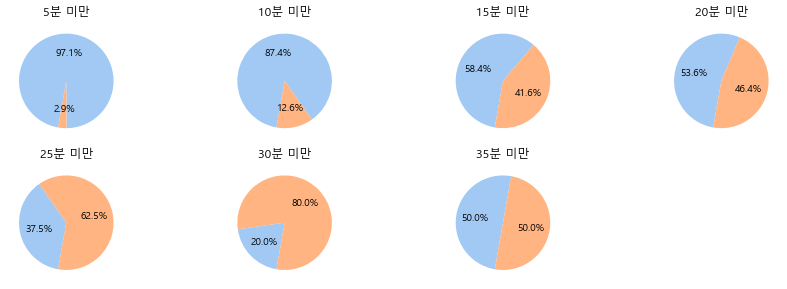

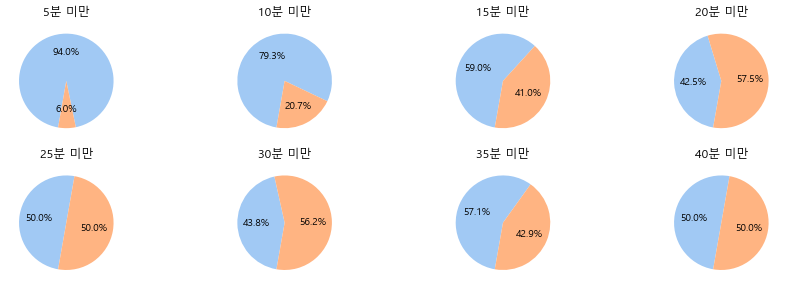

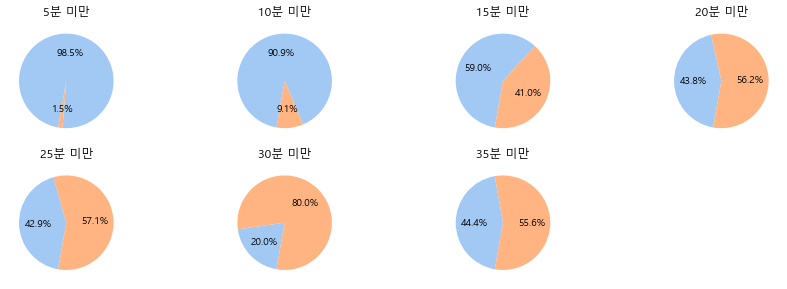

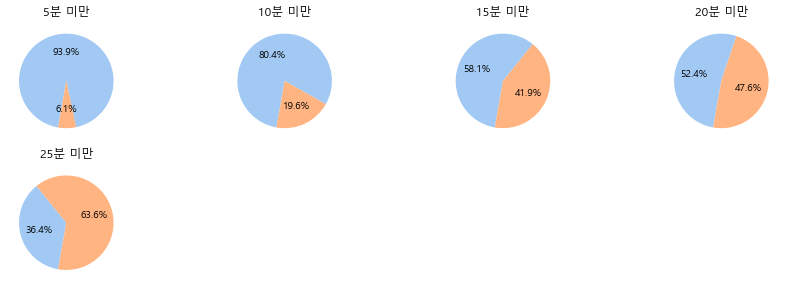

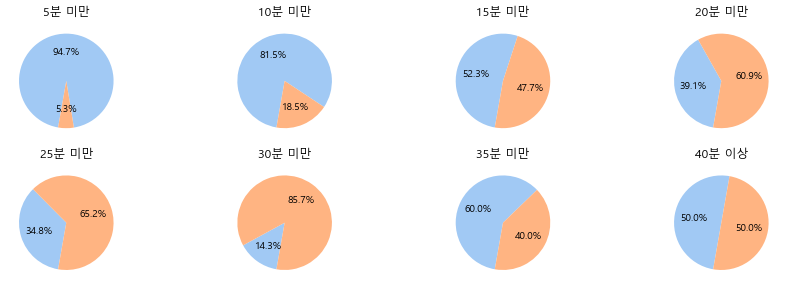

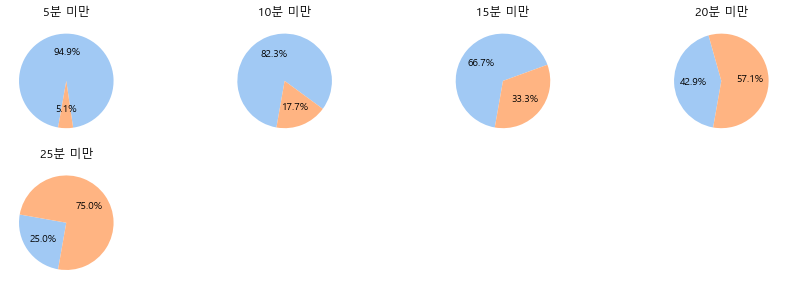

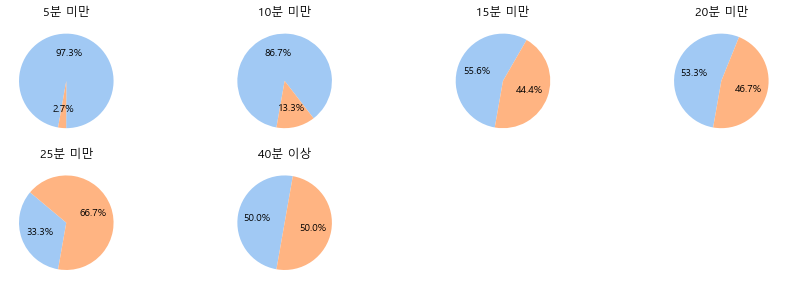

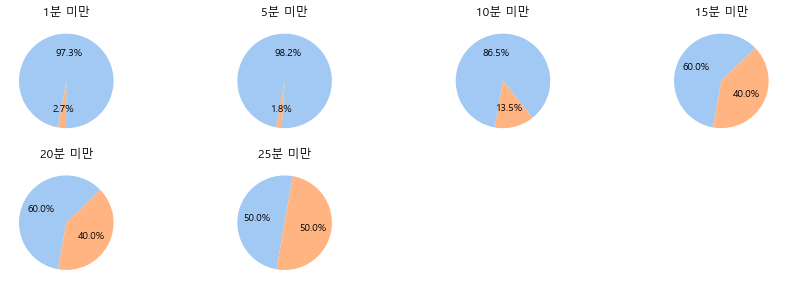

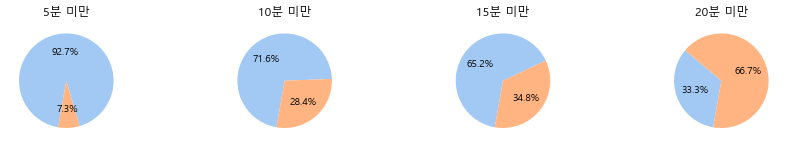

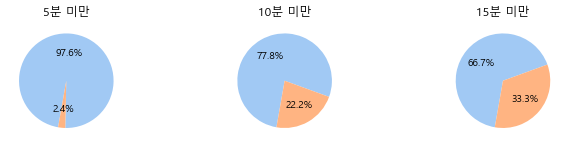

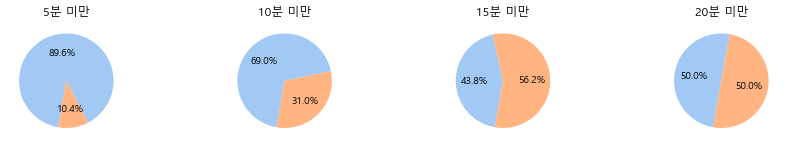

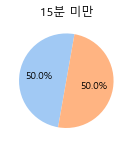

In [92]:
for i in range(len(age_30)):
    job_age_call(df_tel, '30대', age_30[i])

chi-square test : 40대인 서비스종사자
chisq : 739.278
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,609,12,1.932367
10분 미만,162,16,8.988764
15분 미만,35,20,36.363636
20분 미만,11,14,56.000000
30분 미만,1,1,50.000000


,0,1,2
0,493.0,38.0,92.0
1,148.0,11.0,28.0
2,72.0,6.0,14.0
3,64.0,5.0,12.0
4,41.0,3.0,8.0


chi-square test : 40대인 산업노동자
chisq : 2269.299
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,1682,20,1.175088
10분 미만,511,42,7.594937
15분 미만,94,52,35.616438
20분 미만,25,26,50.980392
25분 미만,9,14,60.869565
30분 미만,2,5,71.428571
35분 미만,1,3,75.000000


,0,1,2
0,1419.0,99.0,185.0
1,467.0,33.0,61.0
2,151.0,11.0,20.0
3,85.0,6.0,11.0
4,70.0,5.0,9.0
5,65.0,5.0,9.0
6,66.0,5.0,9.0


chi-square test : 40대인 기술자
chisq : 1289.165
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,948,30,3.067485
10분 미만,230,39,14.498141
15분 미만,53,38,41.758242
20분 미만,11,8,42.105263
25분 미만,6,6,50.000000
30분 미만,2,3,60.000000
35분 미만,1,2,66.666667


,0,1,2
0,742.0,75.0,165.0
1,214.0,22.0,48.0
2,100.0,10.0,22.0
3,46.0,5.0,10.0
4,47.0,5.0,10.0
5,49.0,5.0,11.0
6,53.0,5.0,12.0


chi-square test : 40대인 회사원
chisq : 1677.431
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,1370,79,5.452036
10분 미만,357,78,17.931034
15분 미만,67,57,45.967742
20분 미만,19,31,62.000000
25분 미만,5,13,72.222222
30분 미만,2,3,60.000000
40분 이상,2,1,33.333333


,0,1,2
0,1113.0,160.0,181.0
1,347.0,50.0,56.0
2,130.0,19.0,21.0
3,86.0,12.0,14.0
4,69.0,10.0,11.0
5,50.0,7.0,8.0
6,28.0,4.0,5.0


chi-square test : 40대인 공무원
chisq : 676.643
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,551,25,4.340278
10분 미만,131,15,10.273973
15분 미만,37,19,33.928571
20분 미만,8,9,52.941176
25분 미만,1,2,66.666667


,0,1,2
0,437.0,42.0,101.0
1,118.0,11.0,27.0
2,68.0,7.0,16.0
3,53.0,5.0,12.0
4,52.0,5.0,12.0


chi-square test : 40대인 기업가
chisq : 508.603
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,279,6,2.105263
10분 미만,70,13,15.662651
15분 미만,13,10,43.478261
20분 미만,4,7,63.636364
25분 미만,3,3,50.000000
30분 미만,1,2,66.666667


,0,1,2
0,163.0,18.0,106.0
1,56.0,6.0,37.0
2,38.0,4.0,25.0
3,42.0,5.0,28.0
4,32.0,4.0,21.0
5,40.0,4.0,26.0


chi-square test : 40대인 미취업자
chisq : 209.170
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,184,15,7.537688
10분 미만,38,8,17.391304
15분 미만,9,2,18.181818
20분 미만,1,1,50.000000


,0,1,2
0,136.0,15.0,55.0
1,42.0,5.0,17.0
2,19.0,2.0,8.0
3,34.0,4.0,14.0


chi-square test : 40대인 주부
chisq : 246.915
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,204,6,2.857143
10분 미만,54,12,18.181818
15분 미만,14,2,12.500000
20분 미만,1,1,50.000000


,0,1,2
0,154.0,12.0,47.0
1,61.0,5.0,19.0
2,21.0,2.0,6.0
3,38.0,3.0,12.0


chi-square test : 40대인 은퇴
chisq : 51.711
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,49,1,2.000000
10분 미만,13,1,7.142857
15분 미만,6,2,25.000000


,0,1,2
0,33.0,2.0,17.0
1,14.0,1.0,7.0
2,21.0,1.0,11.0


chi-square test : 40대인 자영업자
chisq : 377.962
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,212,10,4.504505
10분 미만,63,8,11.267606
15분 미만,23,6,20.689655
20분 미만,6,6,50.000000
25분 미만,2,3,60.000000
30분 미만,1,1,50.000000


,0,1,2
0,129.0,14.0,83.0
1,47.0,5.0,30.0
2,28.0,3.0,18.0
3,35.0,4.0,23.0
4,37.0,4.0,24.0
5,30.0,3.0,19.0


chi-square test : 40대인 미확인
chisq : 51.142
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,81,2,2.409639
10분 미만,15,4,21.052632


,0,1,2
0,65.0,4.0,16.0
1,31.0,2.0,7.0


chi-square test : 40대인 학생
chisq : 0.000
p : 1.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,2,2,50.0


,0,1,2
0,2.0,2.0,50.0


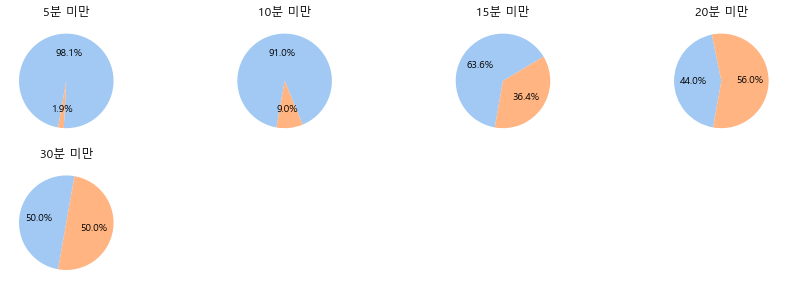

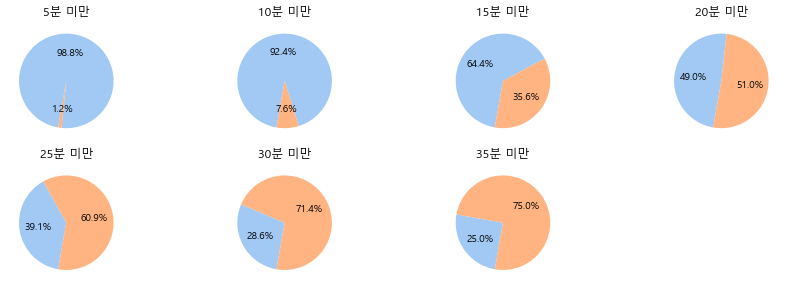

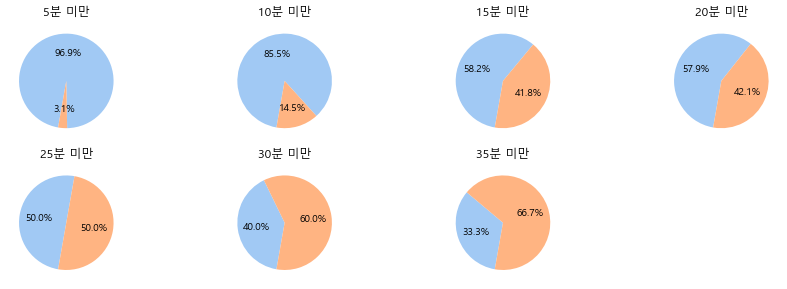

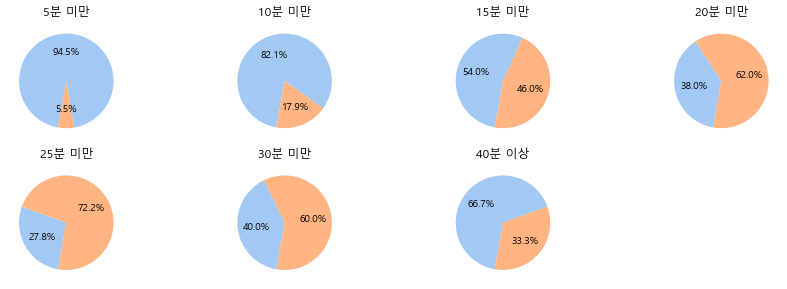

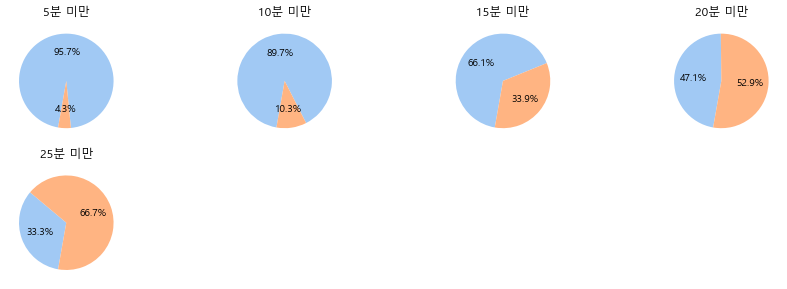

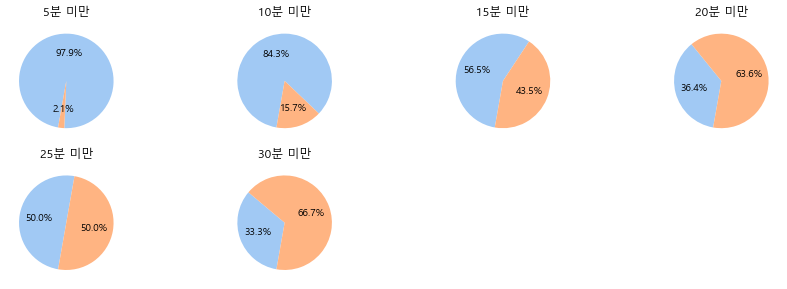

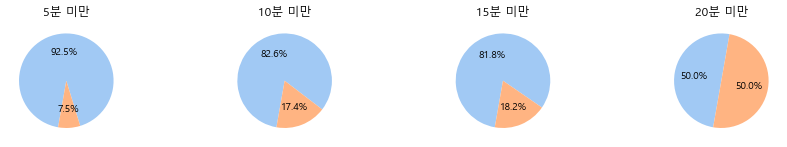

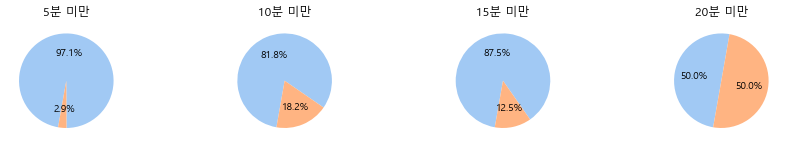

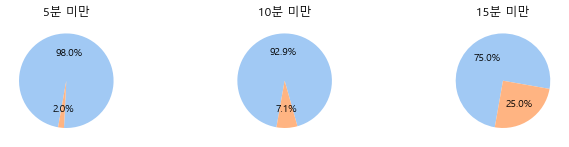

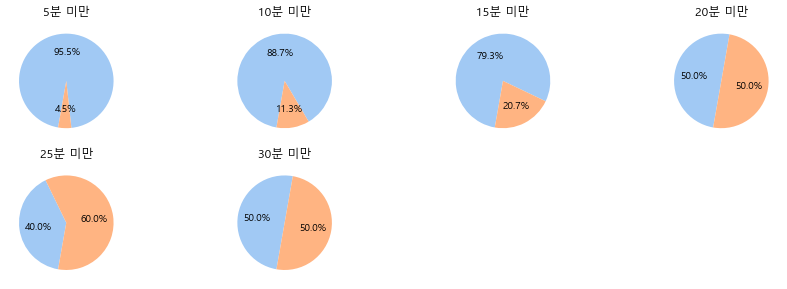

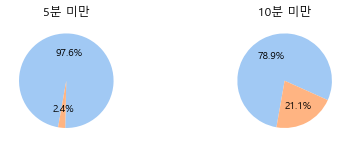

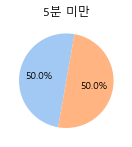

In [93]:
for i in range(len(age_40)):
    job_age_call(df_tel, '40대', age_40[i])

chi-square test : 50대인 주부
chisq : 253.534
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,189,10,5.025126
10분 미만,41,11,21.153846
15분 미만,9,4,30.769231
20분 미만,2,4,66.666667


,0,1,2
0,125.0,15.0,64.0
1,45.0,5.0,23.0
2,27.0,3.0,14.0
3,44.0,5.0,23.0


chi-square test : 50대인 서비스종사자
chisq : 372.541
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,272,4,1.449275
10분 미만,77,12,13.483146
15분 미만,12,7,36.842105
20분 미만,2,4,66.666667


,0,1,2
0,198.0,15.0,65.0
1,73.0,5.0,24.0
2,40.0,3.0,13.0
3,52.0,4.0,17.0


chi-square test : 50대인 회사원
chisq : 1066.824
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,692,63,8.344371
10분 미만,185,59,24.180328
15분 미만,27,26,49.056604
20분 미만,1,14,93.333333
25분 미만,4,3,42.857143
30분 미만,2,5,71.428571
35분 미만,1,1,50.000000


,0,1,2
0,490.0,92.0,182.0
1,172.0,32.0,64.0
2,65.0,12.0,24.0
3,69.0,13.0,26.0
4,32.0,6.0,12.0
5,50.0,9.0,19.0
6,33.0,6.0,12.0


chi-square test : 50대인 은퇴
chisq : 890.992
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,515,29,5.330882
10분 미만,152,42,21.649485
15분 미만,33,18,35.294118
20분 미만,7,13,65.000000
25분 미만,1,7,87.500000
30분 미만,1,2,66.666667
35분 미만,1,1,50.000000


,0,1,2
0,338.0,53.0,158.0
1,133.0,21.0,62.0
2,53.0,8.0,25.0
3,52.0,8.0,24.0
4,59.0,9.0,27.0
5,43.0,7.0,20.0
6,32.0,5.0,15.0


chi-square test : 50대인 산업노동자
chisq : 1098.698
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,709,19,2.609890
10분 미만,215,26,10.788382
15분 미만,52,28,35.000000
20분 미만,10,11,52.380952
25분 미만,2,7,77.777778
30분 미만,1,1,50.000000
40분 이상,1,1,50.000000


,0,1,2
0,531.0,50.0,149.0
1,183.0,17.0,52.0
2,84.0,8.0,24.0
3,53.0,5.0,15.0
4,63.0,6.0,18.0
5,38.0,4.0,11.0
6,38.0,4.0,11.0


chi-square test : 50대인 기술자
chisq : 614.916
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,479,28,5.522682
10분 미만,113,28,19.858156
15분 미만,24,20,45.454545
20분 미만,2,7,77.777778
25분 미만,4,3,42.857143


,0,1,2
0,354.0,49.0,109.0
1,111.0,15.0,34.0
2,62.0,9.0,19.0
3,60.0,8.0,18.0
4,34.0,5.0,11.0


chi-square test : 50대인 미확인
chisq : 77.107
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,49,4,7.547170
10분 미만,13,1,7.142857
15분 미만,2,2,50.000000


,0,1,2
0,29.0,3.0,29.0
1,10.0,1.0,10.0
2,25.0,3.0,26.0


chi-square test : 50대인 공무원
chisq : 543.717
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,367,21,5.412371
10분 미만,112,27,19.424460
15분 미만,20,11,35.483871
20분 미만,5,8,61.538462
25분 미만,1,4,80.000000


,0,1,2
0,255.0,36.0,102.0
1,103.0,14.0,41.0
2,43.0,6.0,17.0
3,48.0,7.0,19.0
4,55.0,8.0,22.0


chi-square test : 50대인 미취업자
chisq : 147.978
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,83,12,12.631579
10분 미만,14,8,36.363636
15분 미만,6,3,33.333333
20분 미만,3,1,25.000000
25분 미만,1,1,50.000000


,0,1,2
0,40.0,9.0,59.0
1,22.0,5.0,32.0
2,16.0,4.0,23.0
3,11.0,3.0,16.0
4,19.0,4.0,28.0


chi-square test : 50대인 기업가
chisq : 184.967
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,170,2,1.162791
10분 미만,43,7,14.000000
15분 미만,7,6,46.153846


,0,1,2
0,129.0,9.0,36.0
1,48.0,3.0,13.0
2,44.0,3.0,12.0


chi-square test : 50대인 자영업자
chisq : 291.432
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,135,3,2.173913
10분 미만,41,6,12.765957
15분 미만,10,3,23.076923
20분 미만,2,4,66.666667
25분 미만,1,3,75.000000


,0,1,2
0,68.0,7.0,65.0
1,29.0,3.0,28.0
2,18.0,2.0,17.0
3,35.0,4.0,34.0
4,39.0,4.0,37.0


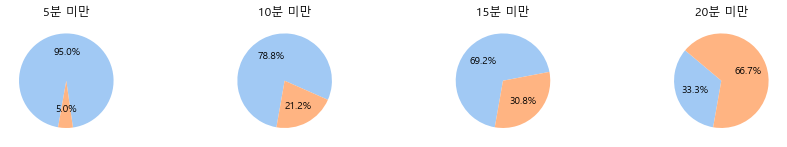

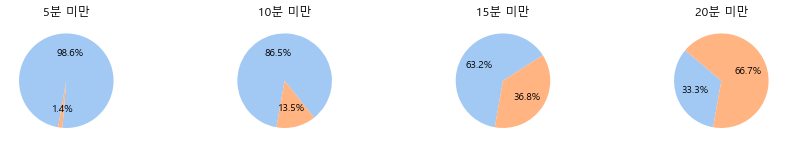

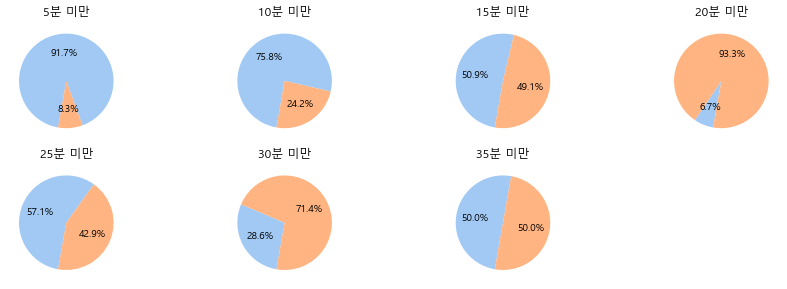

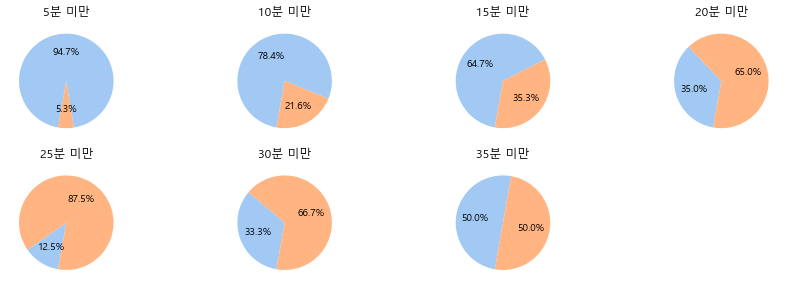

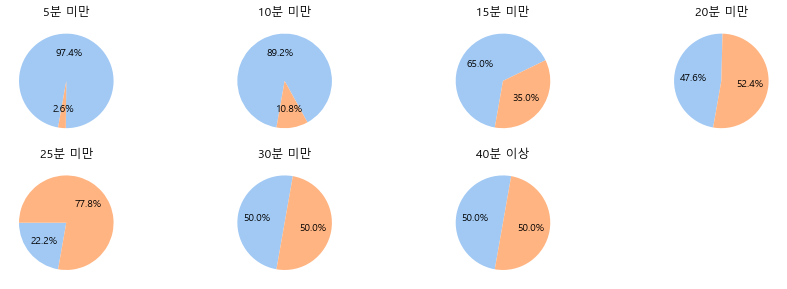

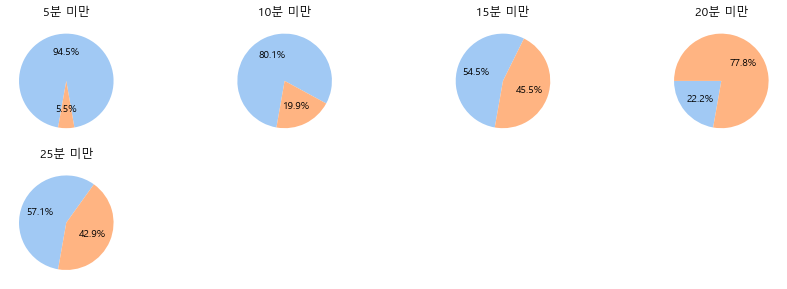

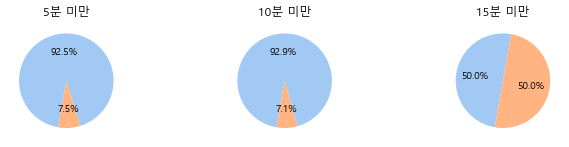

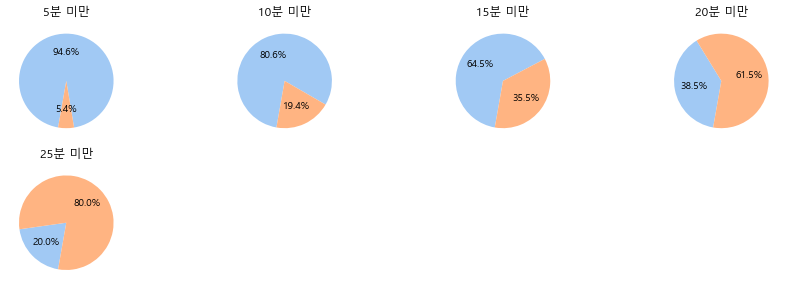

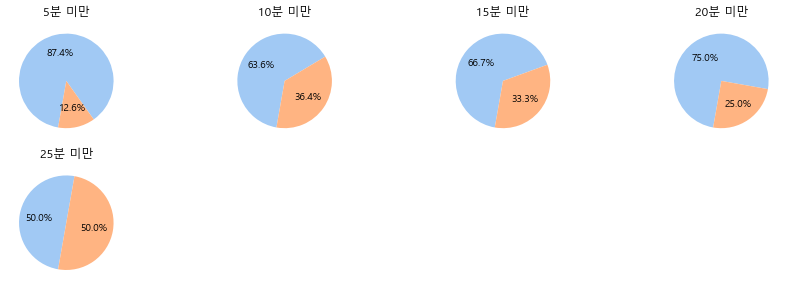

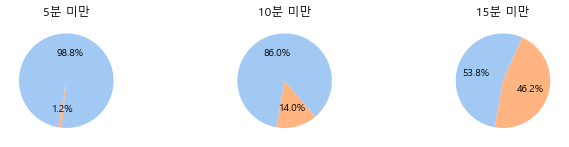

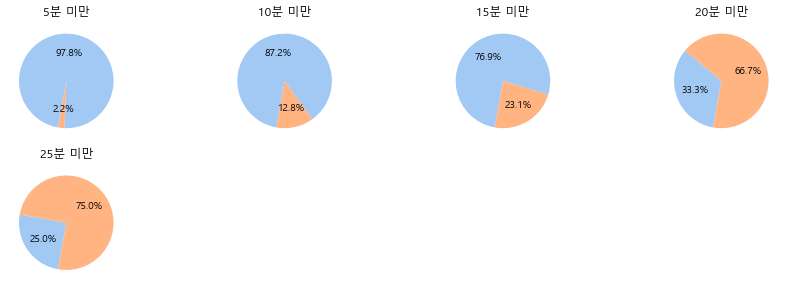

In [94]:
for i in range(len(age_50)):
    job_age_call(df_tel, '50대', age_50[i])

In [110]:
df_tel[df_tel['Age']=='60대']['직업군'].unique()

array(['은퇴', '회사원', '기술자', '주부', '자영업자', '공무원', '미취업자', '미확인', '산업노동자',
       '기업가', '서비스종사자'], dtype=object)

In [111]:
df_60 = df_tel[(df_tel['Age']=='60대') & (df_tel['직업군']=='산업노동자')].sort_values(by='직업군').head(50)
call_time = df_60.groupby(['통화시간대2', '계약여부'])['계약여부'].count().unstack('계약여부').fillna(0)
idx = call_time.loc[(call_time['no'] == 0) | (call_time['yes'] == 0)].index
call_time = call_time.drop(idx)
call_time['%'] = (call_time['yes'] / (call_time['no'] + call_time['yes']))*100
call_time

계약여부,no,yes,%
통화시간대2,,,
5분 미만,11,3,21.428571
10분 미만,2,2,50.000000


chi-square test : 60대인 은퇴
chisq : 284.141
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,126,74,37.000000
10분 미만,25,48,65.753425
15분 미만,5,8,61.538462
20분 미만,1,2,66.666667
25분 미만,1,2,66.666667


,0,1,2
0,64.0,54.0,120.0
1,37.0,32.0,70.0
2,20.0,17.0,38.0
3,19.0,16.0,35.0
4,19.0,16.0,35.0


chi-square test : 60대인 회사원
chisq : 28.296
p : 0.000011


계약여부,no,yes,%
통화시간대2,,,
5분 미만,15,12,44.444444
10분 미만,3,8,72.727273
35분 미만,1,1,50.000000


,0,1,2
0,7.0,7.0,58.0
1,8.0,8.0,68.0
2,5.0,5.0,42.0


chi-square test : 60대인 기술자
chisq : 29.695
p : 0.000000


계약여부,no,yes,%
통화시간대2,,,
5분 미만,18,10,35.714286
10분 미만,1,2,66.666667


,0,1,2
0,9.0,6.0,49.0
1,10.0,6.0,53.0


chi-square test : 60대인 주부
chisq : 17.618
p : 0.000149


계약여부,no,yes,%
통화시간대2,,,
5분 미만,15,6,28.571429
10분 미만,3,5,62.500000


,0,1,2
0,7.0,5.0,38.0
1,11.0,6.0,53.0


KeyError: 'yes'

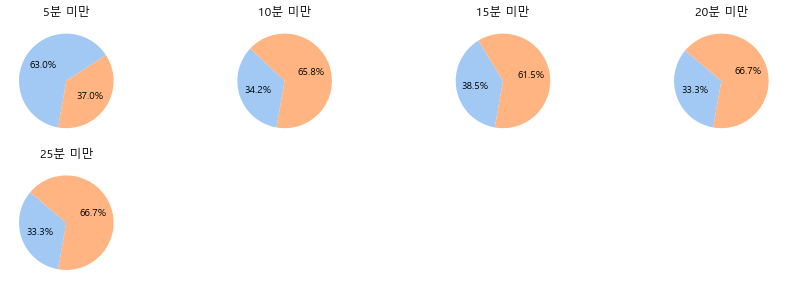

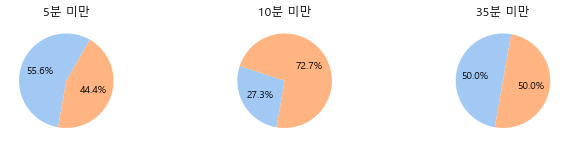

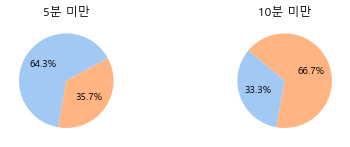

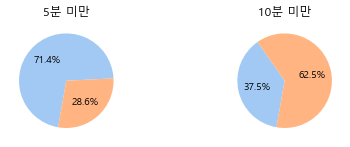

In [95]:
for i in range(len(age_60)):
    job_age_call(df_tel, '60대', age_60[i])

In [17]:
df_tel['p_days'].fillna('안함', inplace=True)
df_tel['재연락'] = np.where(df_tel['p_days'] == '안함', 0, 1)

In [21]:
df_tel.head()

,연령,직업군,결혼여부,학력,신용카드소지여부,주택대출여부,개인대출여부,contact,통화시간,연락시도횟수,p_days,과거통화횟수,계약여부,연락일자,카드종류,Age,통화시간대2,재연락
0,56,주부,결혼,중졸,없음,없음,없음,유선전화,261,1,안함,0,no,2018-01-03,87,50대,5분 미만,0
1,57,서비스종사자,결혼,전문학교,미확인,없음,없음,유선전화,149,1,안함,0,no,2018-01-03,88,50대,5분 미만,0
2,37,서비스종사자,결혼,전문학교,없음,대출있음,없음,유선전화,226,1,안함,0,no,2018-01-03,89,30대,5분 미만,0
3,40,회사원,결혼,검정고시,없음,없음,없음,유선전화,151,1,안함,0,no,2018-01-03,90,30대,5분 미만,0
4,56,서비스종사자,결혼,전문학교,없음,없음,대출있음,유선전화,307,1,안함,0,no,2018-01-03,91,50대,10분 미만,0


In [22]:
df_tel.drop(['연령', '통화시간'], axis=1, inplace=True)
df_tel.to_csv('Telemarketing Data_1.csv', index=False, encoding='cp949')